# Think Bayes: Chapter 7

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from sympy import symbols
import math
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb
import scipy.stats

'Done'

'Done'

## Warm-up exercises

**Exercise:** Suppose that goal scoring in hockey is well modeled by a 
Poisson process, and that the long-run goal-scoring rate of the
Boston Bruins against the Vancouver Canucks is 2.9 goals per game.
In their next game, what is the probability
that the Bruins score exactly 3 goals?  Plot the PMF of `k`, the number
of goals they score in a game.

P(3 goals) = 0.224


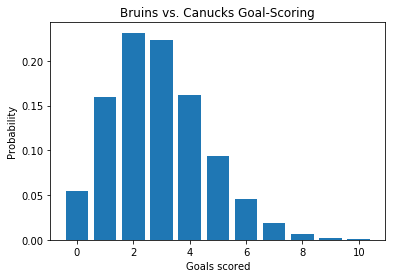

In [2]:
rv = scipy.stats.poisson(2.9)
K = np.linspace(0, 10, 11)

print('P(3 goals) = %.3lf' % rv.pmf(3))

plt.bar(K, rv.pmf(K))
plt.xlabel('Goals scored')
plt.ylabel('Probability')
plt.title('Bruins vs. Canucks Goal-Scoring')
plt.show()

**Exercise:**  Assuming again that the goal scoring rate is 2.9, what is the probability of scoring a total of 9 goals in three games?  Answer this question two ways:

1.  Compute the distribution of goals scored in one game and then add it to itself twice to find the distribution of goals scored in 3 games.

2.  Use the Poisson PMF with parameter $\lambda t$, where $\lambda$ is the rate in goals per game and $t$ is the duration in games.

In [3]:
# Constants used throughout.
MAX_GOALS_PER_GAME = 10
MAX_GAMES_BETWEEN_GOALS = 2

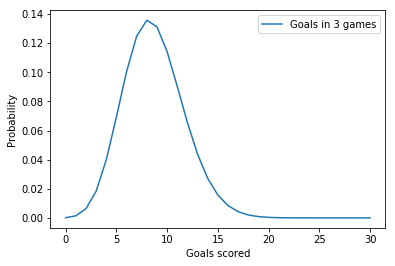

0.13117020107678162

In [4]:
t = 3
K = np.arange(MAX_GOALS_PER_GAME + 1)
goals_pmf = mtb.PMF(K, scipy.stats.poisson(2.9).pmf(K))
t_games_pmf = goals_pmf + goals_pmf + goals_pmf
t_games_pmf.plot(label='Goals in %d games' % t)
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Goals scored')
plt.show()

t_games_pmf[9]

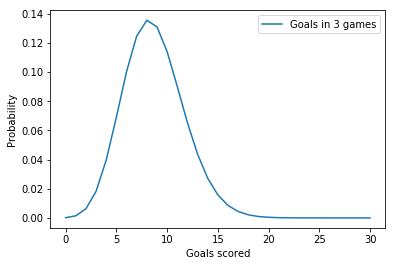

0.13108356669746382

In [5]:
K = np.arange(MAX_GOALS_PER_GAME * t + 1)
goals_pmf = mtb.PMF(K, scipy.stats.poisson(2.9 * t).pmf(K))
goals_pmf.plot(label='Goals in %d games' % t)
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Goals scored')
plt.show()
goals_pmf[9]

**Exercise:** Suppose that the long-run goal-scoring rate of the
Canucks against the Bruins is 2.6 goals per game.  Plot the distribution
of `t`, the time until the Canucks score their first goal.
In their next game, what is the probability that the Canucks score
during the first period (that is, the first third of the game)?

Hint: `thinkbayes2` provides `MakeExponentialPmf` and `EvalExponentialCdf`.

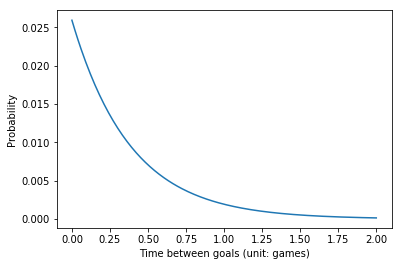

P(goal in first period) = 0.592


In [6]:
lam = 2.6
T = np.linspace(0, MAX_GAMES_BETWEEN_GOALS, 200)

# TODO: change this to use scipy.stats.expon.
time_pmf = mtb.PMF(T, scipy.stats.expon(scale=1/lam).pdf(T))
time_pmf.plot()
plt.xlabel('Time between goals (unit: games)')
plt.ylabel('Probability')
plt.show()

# Convert to CDF to get the probability of scoring in first period.
time_cdf = time_pmf.to_cdf()
print('P(goal in first period) = %.3lf' % (time_cdf < (1/3)))

**Exercise:** Assuming again that the goal scoring rate is 2.8, what is the probability that the Canucks get shut out (that is, don't score for an entire game)?  Answer this question two ways, using the CDF of the exponential distribution and the PMF of the Poisson distribution.

In [7]:
# Using PMF of Poisson.
lam = 2.6
print('P(shutout) = %.4lf' % scipy.stats.poisson(lam).pmf(0))

# Using the CCDF of the Exponential distribution.
print('P(shutout) = %.4lf' % (1 - (1 - np.exp(-lam * 1))))

P(shutout) = 0.0743
P(shutout) = 0.0743


## The Boston Bruins problem

The `Hockey` suite contains hypotheses about the goal scoring rate for one team against the other.  The prior is Gaussian, with mean and variance based on previous games in the league.

The Likelihood function takes as data the number of goals scored in a game.

**Summary of steps**

1. Use statistics from prior games to choose a distribution for the parameter $\lambda$, which parameterizes the Poisson process for the number of goals scored per game.
2. Use the scores from the first four games to update the $\lambda$ prior for each team.
3. Use the posterior of $\lambda$ to compute:
    - distribution of goals for each team
    - distribution of the goal differential
    - probability each team wins the next game
    
4. Compute probability that each team wins the series

In [8]:
class ScoringRate(mtb.PMF):
    """PMF for a team's scoring rate (Lambda). 
    
    Lambda parameterizes the Poisson process which controls 
    the number of goals a team scores per game.
    
    The prior for Lambda is a normal with mean mu and standard 
    deviation sigma computed from previous games."""
    
    def __init__(self, mu=2.8, sigma=0.3):
        lo = mu - 4 * sigma
        hi = mu + 4 * sigma
        hypos = np.linspace(lo, hi, 101)
        super().__init__(hypos, scipy.stats.norm(mu, sigma).pdf(hypos))
    
    def likelihood(self, data, hypo):
        """Compute P(data | hypo) = P(number of goals | lambda poisson parameter).
        """
        lam = hypo
        n_goals = data
        return scipy.stats.poisson(lam).pmf(n_goals)
    
'Done'

'Done'

Now we can initialize a suite for each team. Their priors are identical.

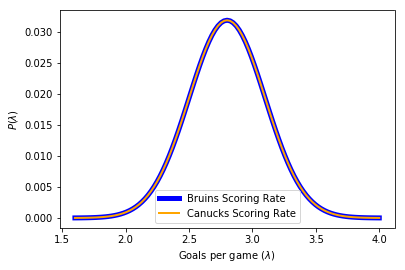

In [9]:
sr_b = ScoringRate()
sr_c = ScoringRate()

sr_b.plot(linewidth=5, color='blue', label='Bruins Scoring Rate')
sr_c.plot(linewidth=2, color='orange', label='Canucks Scoring Rate')
plt.xlabel('Goals per game ($\lambda$)')
plt.ylabel('$P(\lambda)$')
plt.legend()
plt.show()

And we can update each suite with the scores from the first 4 games.

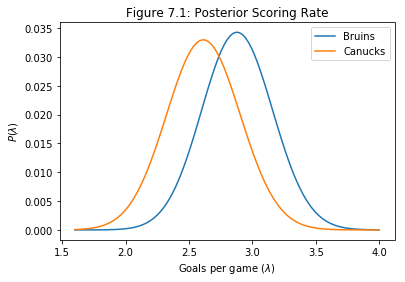

In [10]:
sr_b = ScoringRate()
sr_c = ScoringRate()

for n in [0, 2, 8, 4]:
    sr_b.update(n)
    
for n in [1, 3, 1, 0]:
    sr_c.update(n)

sr_b.plot(label='Bruins')
sr_c.plot(label='Canucks')
plt.xlabel('Goals per game ($\lambda$)')
plt.ylabel('$P(\lambda)$')
plt.title('Figure 7.1: Posterior Scoring Rate')
plt.legend()
plt.show()

To predict the number of goals scored in the next game we can compute, for each hypothetical value of $\lambda$, a Poisson distribution of goals scored, then make a weighted mixture of Poissons:

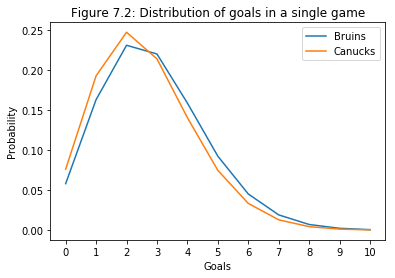

In [11]:
def make_goals_per_game_mix(sr_pmf, max_goals_per_game):

    K = np.arange(max_goals_per_game + 1)
    
    pmfs = [
        (mtb.PMF(K, scipy.stats.poisson(lam).pmf(K)), prob)
        for lam, prob in sr_pmf.items()
    ]
    
    gpg_mix = mtb.PMF.from_mixture(pmfs)
    return gpg_mix

gpg_b = make_goals_per_game_mix(sr_b, MAX_GOALS_PER_GAME)
gpg_c = make_goals_per_game_mix(sr_c, MAX_GOALS_PER_GAME)

plt.plot(gpg_b.hypos, gpg_b.probs, label='Bruins')
plt.plot(gpg_c.hypos, gpg_c.probs, label='Canucks')
plt.xticks(range(MAX_GOALS_PER_GAME + 1), range(MAX_GOALS_PER_GAME + 1))
plt.title('Figure 7.2: Distribution of goals in a single game')
plt.xlabel('Goals')
plt.ylabel('Probability')
plt.legend()
plt.show()

Now we can compute the probability that the Bruins win, lose, or tie in regulation time.

In [12]:
gpg_diff_pmf = gpg_b - gpg_c
gpg_diff_cdf = gpg_diff_pmf.to_cdf()

# display(gpg_diff_cdf.to_ccdf())

p_win_reg = gpg_diff_cdf > 0  # Goal differential > 0.
p_los_reg = gpg_diff_cdf < 0  # Goal differenctial < 0.
p_tie_reg = gpg_diff_pmf[0]   # Goal differential == 0.

print('P(win) = %.4lf' % p_win_reg)
print('P(lose) = %.3lf' % p_los_reg)
print('P(tie) = %.3lf' % p_tie_reg)

P(win) = 0.4580
P(lose) = 0.370
P(tie) = 0.172


If the game goes into overtime, we have to compute the distribution of `t`, the time until the first goal, for each team.  For each hypothetical value of $\lambda$, the distribution of `t` is exponential, so the predictive distribution is a mixture of exponentials.

Here's what the predictive distributions for `t` look like.

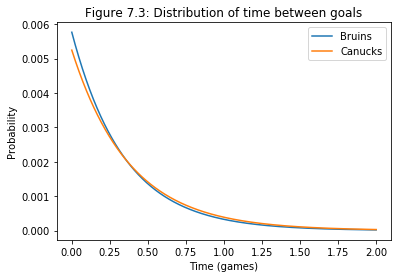

In [13]:

def make_time_between_goals_mix(sr_pmf, max_games_between_goals):
    
    T = np.linspace(0, max_games_between_goals, 1001)
    
    pmfs = [
        (mtb.PMF(T, scipy.stats.expon(scale=1/lam).pdf(T)), prob)
        for lam, prob in sr_pmf.items()
    ]
    
    tbg_mix = mtb.PMF.from_mixture(pmfs)
    return tbg_mix

tbg_b = make_time_between_goals_mix(sr_b, MAX_GAMES_BETWEEN_GOALS)
tbg_c = make_time_between_goals_mix(sr_c, MAX_GAMES_BETWEEN_GOALS)

tbg_b.plot(label='Bruins')
tbg_c.plot(label='Canucks')
plt.title('Figure 7.3: Distribution of time between goals')
plt.xlabel('Time (games)')
plt.ylabel('Probability')
plt.legend()
plt.show()

In overtime the first team to score wins, so the probability of winning is the probability of generating a smaller value of `t`:

In [14]:
# Adjustment in case of a tie (both teams score at same time),
# which cannot happen. So each team gets half of this probability.
p_tie = (tbg_b == tbg_c)
p_win_over = (tbg_b < tbg_c) + (p_tie / 2)

print('P(Bruins win in overtime) = %.4lf' % p_win_over)

P(Bruins win in overtime) = 0.5235


Finally, we can compute the overall chance that the Bruins win, either in regulation or overtime.

In [15]:
p_win_overall = p_win_reg + p_tie_reg * p_win_over
print('p_win_overall', p_win_overall)

p_win_overall 0.5478856317411259


In [16]:
'Done'

'Done'

## Exercises

**Exercise:** To make the model of overtime more correct, we could update both suites with 0 goals in one game, before computing the predictive distribution of `t`.  Make this change and see what effect it has on the results.

In [17]:
# The Bruin's probability of winning increases slightly.
sr_b = ScoringRate()
sr_c = ScoringRate()

for n in [0, 2, 8, 4]:
    sr_b.update(n)
    
for n in [1, 3, 1, 0]:
    sr_c.update(n)
    
sr_b.update(0)
sr_c.update(0)

tbg_b = make_time_between_goals_mix(sr_b, MAX_GAMES_BETWEEN_GOALS)
tbg_c = make_time_between_goals_mix(sr_c, MAX_GAMES_BETWEEN_GOALS)

p_tie = (tbg_b == tbg_c)
p_win_over = (tbg_b < tbg_c) + (p_tie / 2)
print('P(Bruins win in overtime) = %.5f' % p_win_over)

p_win_overall = p_win_reg + p_tie_reg * p_win_over
print('P(Bruins win overall) = %.5lf' % p_win_overall)

P(Bruins win in overtime) = 0.52461
P(Bruins win overall) = 0.54808


**Exercise:** In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. What is the probability that Germany had the better team?  What is the probability that Germany would win a rematch?

For a prior distribution on the goal-scoring rate for each team, use a gamma distribution with parameter 1.3.

E[Goals] = 1.310


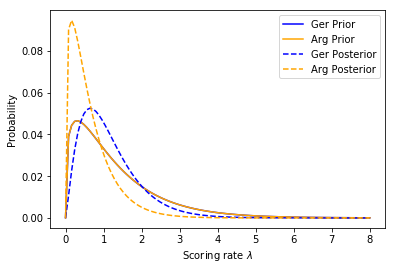

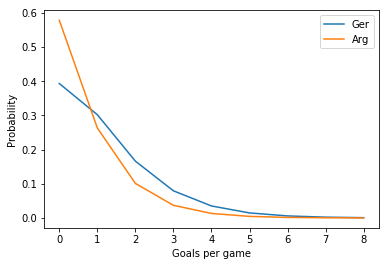

P(Ger wins) = 0.44769
P(Arg wins) = 0.22518
P(Tie) = 0.32713


In [18]:
class ScoringRateSoccer(mtb.PMF):
    """Same as hockey ScoringRate class, but uses a gamma prior.
    
    This makes intuitive sense because goals are much more rare in soccer
    than in hockey for the same amount of time played."""
    
    def __init__(self, a=1.3):
        hypos = np.linspace(0, 8, 101)
        super().__init__(hypos, scipy.stats.gamma(a).pdf(hypos))
    
    def likelihood(self, data, hypo):
        """Compute P(data | hypo) = P(number of goals | lambda poisson parameter).
        """
        lam = hypo
        n_goals = data
        return scipy.stats.poisson(lam).pmf(n_goals)

# Set the priors.
sr_g = ScoringRateSoccer()
sr_a = ScoringRateSoccer()
sr_g.plot(label='Ger Prior', color='blue')
sr_a.plot(label='Arg Prior', color='orange')
print('E[Goals] = %.3lf' % sr_g.expectation())

# Update with goals from this match.
sr_g.update(1)
sr_a.update(0)
sr_g.plot(label='Ger Posterior', color='blue', linestyle='--')
sr_a.plot(label='Arg Posterior', color='orange', linestyle='--')

# Plot priors and posteriors.
plt.legend()
plt.xlabel('Scoring rate $\lambda$')
plt.ylabel('Probability')
plt.show()

# Make mixtures for the number of goals actually scored.
gpg_g = make_goals_per_game_mix(sr_g, 8)
gpg_a = make_goals_per_game_mix(sr_a, 8)
gpg_g.plot(label='Ger')
gpg_a.plot(label='Arg')
plt.legend()
plt.xlabel('Goals per game')
plt.ylabel('Probability')
plt.show()

# Compute goal differential distribution and probabilities of game results.
print('P(Ger wins) = %.5lf' % (gpg_g > gpg_a))
print('P(Arg wins) = %.5lf' % (gpg_g < gpg_a))
print('P(Tie) = %.5lf' % (gpg_g == gpg_a))

**Exercise:** In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game. 

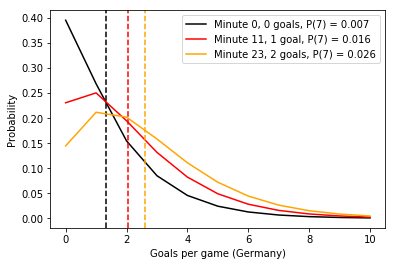

In [19]:
class ScoringRateSoccer2(mtb.PMF):
    """
    ~~PMF over "t", which parameterizes the minutes between goals in a soccer game.~~
    """
    
    def __init__(self, a=1.3, max_goals_in_game=10, max_mins_between_goals=3 * 90):
        
        # Make prior for scoring rate lambda (unit: goals per game)
        hypos = np.linspace(0, max_goals_in_game + 1, 101)
        probs = scipy.stats.gamma(a).pdf(hypos)
        
        super().__init__(hypos, probs)
            
    def goals_per_game(self, max_goals_in_game=10):
        G = np.arange(max_goals_in_game + 1)
        pmfs = [
            (mtb.PMF(G, scipy.stats.poisson(lam).pmf(G)), prob)
            for lam, prob in self.items()
        ]
        return mtb.PMF.from_mixture(pmfs)
        
    
    def likelihood(self, data, hypo):
        """P(data | hypo) = P(games since last goal | scoring rate parameter lambda).
        """
        lam = hypo
        mins_since_goal = data
        games_since_goal = mins_since_goal / 90
        return scipy.stats.expon(scale=1 / lam).pdf(games_since_goal)

# Setup prior for scoring rate.
game = ScoringRateSoccer2()

gpg = game.goals_per_game()
gpg.plot(label='Minute 0, 0 goals, P(7) = %.3lf' % gpg[7], color='black')
plt.axvline(gpg.expectation(), color='black', linestyle='--')

game.update(11)
gpg = game.goals_per_game()
gpg.plot(label='Minute 11, 1 goal, P(7) = %.3lf' % gpg[7], color='red')
plt.axvline(gpg.expectation(), color='red', linestyle='--')

game.update(23 - 11)
gpg = game.goals_per_game()
gpg.plot(label='Minute 23, 2 goals, P(7) = %.3lf' % gpg[7], color='orange')
plt.axvline(gpg.expectation(), color='orange', linestyle='--')

plt.xlabel('Goals per game (Germany)')
plt.ylabel('Probability')
plt.legend()
plt.show()

**Exercise:** Which is a better way to break a tie: overtime or penalty shots?

I'm not sure what defines a *better* tiebreaker in this situation, but I'll outline a potential solution.

Perhaps one definition would be that you want the better team to win, where the better team might be:
- Team with a higher historic scoring rate.
- Team that scored the most recent goal.
- Team picked by expert oddsmakers.

If you can assume that there is a better team in some metric, then you could:
1. Simulate (or analytically derive) both overtime and penalty shots.
2. Count how many times the better team wins for both overtime and penalty shots.
3. Conclude that the better tiebreaker is the one in which the better team wins most often.

**Exercise:** Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.
If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

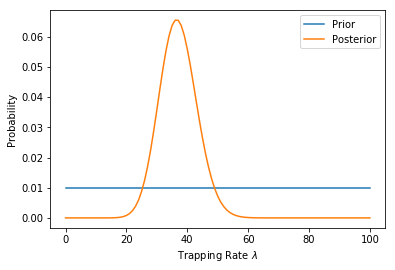

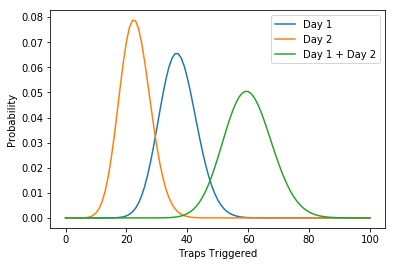

In [22]:
class TrappingRate(mtb.PMF):
    
    def likelihood(self, hypo, data):
        lam = hypo
        n_trapped = data
        return scipy.stats.poisson(lam).pmf(n_trapped)

N_TRAPS_TOTAL = 100
N_TRAPS_TRIGGERED_TRIAL = 37
    
# Make a prior over trapping rates and update it with 37 triggered traps.
tr_pmf = TrappingRate(range(N_TRAPS_TOTAL + 1))
tr_pmf.plot(label='Prior')
tr_pmf.update(N_TRAPS_TRIGGERED_TRIAL)
tr_pmf.plot(label='Posterior')
plt.xlabel('Trapping Rate $\lambda$')
plt.ylabel('Probability')
plt.legend()
plt.show()

# Now the traps are reset and left for two days.
# The distribution over triggered traps for day 1 is
# the same as the trapping rate prior..
d1_pmf = tr_pmf.copy()
d1_pmf.plot(label='Day 1')

# The number of traps triggered on day 2 is affected
# by the number that were triggered on day 1. For example,
# if there are 40 traps triggered on day 1, then there
# can be at most 60 triggered on day 2. To model this,
# we can make a mixture of poisson PMFs. Each PMF uses
# the day 1 count as its trapping rate and is weighted
# by the probability of that count.

pmfs = []
for d1, weight in d1_pmf.items():
    d2_max = N_TRAPS_TOTAL - d1
    d2_lam = d1 / N_TRAPS_TOTAL * d2_max
    hypos = np.arange(d2_max + 1)
    probs = scipy.stats.poisson(d2_lam).pmf(hypos)
    pmfs.append((mtb.PMF(hypos, probs), weight))

d2_pmf = mtb.PMF.from_mixture(pmfs)
d2_pmf.plot(label='Day 2')

# Sum the triggered traps on day 1 and day 2, deleting any 
# sums which exceed the total number of traps.
sum_pmf = d1_pmf + d2_pmf
for h in sum_pmf.hypos:
    if h > N_TRAPS_TOTAL:
        del sum_pmf[h]
sum_pmf.normalize()
sum_pmf.plot(label='Day 1 + Day 2')

plt.xlabel('Traps Triggered')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [21]:
'Done'

'Done'